In [41]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [42]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from os import path
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
spark = SparkSession.builder.appName('RedditData').config("spark.jars.packages").getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.app.startTime', '1638573479532'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'cluster-8bac-m'),
 ('spark.eventLog.dir',
  'gs://dataproc-temp-us-central1-84427460872-fixxspuh/c5c5b347-8c75-4331-a6af-4b0e98365fe5/spark-job-history'),
 ('spark.driver.memory', '4g'),
 ('spark.sql.warehouse.dir', 'file:/spark-warehouse'),
 ('spark.yarn.am.memory', '640m'),
 ('spark.app.id', 'application_1638572602897_0002'),
 ('spark.cores.max', '4'),
 ('spark.executor.cores', '4'),
 ('spark.executor.instances', '2'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.host',
  'cluster-8bac-m.us-central1-b.c.big-data-platforms-329618.internal'),
 ('spark.yarn.unmanagedAM.enabled', 'true'),
 ('spark.sql.autoBroadcastJoinThreshold', '43m'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpF

In [44]:
bucket_name="reddit-data-team-1"
path=f"gs://{bucket_name}/Reddit_data.csv"

df=spark.read.csv(path, header=True)

In [45]:
df.show()

+--------------------------------+----+------------+---------+----------+------------+----------------------+--------------------+---------------+-------+--------------+------+-----+--------+---------------+-----+------------+--------------------+-------------+------+----------------+----------+
|                     created_utc| ups|subreddit_id|  link_id|      name|score_hidden|author_flair_css_class|   author_flair_text|      subreddit|     id|removal_reason|gilded|downs|archived|         author|score|retrieved_on|                body|distinguished|edited|controversiality| parent_id|
+--------------------------------+----+------------+---------+----------+------------+----------------------+--------------------+---------------+-------+--------------+------+-----+--------+---------------+-----+------------+--------------------+-------------+------+----------------+----------+
|                      1430438400|   4|    t5_378oi|t3_34di91|t1_cqug90g|           0|                  null|

In [46]:
df.describe()

DataFrame[summary: string, created_utc: string, ups: string, subreddit_id: string, link_id: string, name: string, score_hidden: string, author_flair_css_class: string, author_flair_text: string, subreddit: string, id: string, removal_reason: string, gilded: string, downs: string, archived: string, author: string, score: string, retrieved_on: string, body: string, distinguished: string, edited: string, controversiality: string, parent_id: string]

In [5]:
subr_df = df.groupby('subreddit').count().sort('count', ascending =False)

In [6]:
subr_df_pd = subr_df.toPandas()

In [7]:
subr_df_pd

,subreddit,count
0,None,15201409
1,AskReddit,2207695
2,leagueoflegends,673175
3,nba,412018
4,funny,407065
...,...,...
295001,"that you might want to get rid of.""",1
295002,t1_crbjhjo,1
295003,up from single cells to beings that could wri...,1
295004,t3_3688mm,1


In [9]:
new_df = subr_df_pd[1:]
new_df = new_df.sort_values(by=["count"], ascending=[False]).head(10)

Text(0.5, 1.0, 'Top 10 Subreddits with most comments')

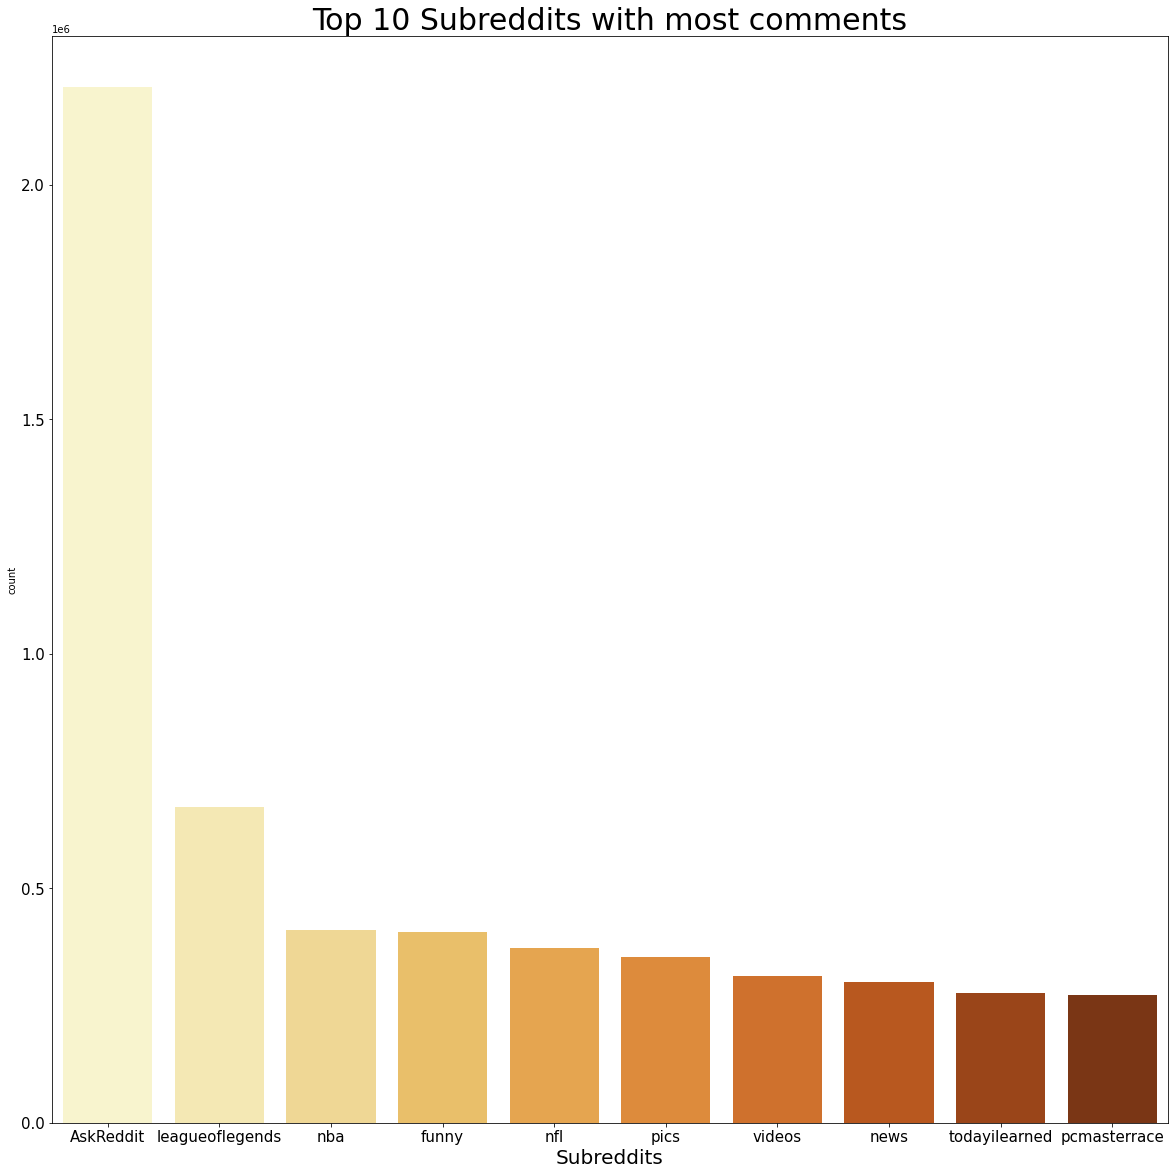

In [23]:
plt.subplots(figsize=(20, 20))
b = sns.barplot(x='subreddit',y='count',data=new_df,palette = "YlOrBr")
b.set_xlabel("Subreddits",fontsize=20)
b.tick_params(labelsize=15)
plt.title('Top 10 Subreddits with most comments',fontsize=30)

Finding the top 10 most controversial subreddits

In [40]:
df.select('removal_reason').distinct().collect()

[Row(removal_reason='t1_cqttj5i'),
 Row(removal_reason=' and I wish the artists who see sexism in hip-hop would be much more vocal about condemning it than they are now.'),
 Row(removal_reason=' generation after generation'),
 Row(removal_reason='t3_34gw6t'),
 Row(removal_reason=' not so with a frequency. We have a cell tower and we had WiFi before'),
 Row(removal_reason=" and you've got the situation for the first few years that a male-looking person enters a women's room. They know they have to be on their best behavior"),
 Row(removal_reason='t1_cqu1kph'),
 Row(removal_reason='cquir88'),
 Row(removal_reason='t1_cquitxu'),
 Row(removal_reason=' which helps boost that.  '),
 Row(removal_reason=" I'll usually set the hammock up so I've got a place to sit."),
 Row(removal_reason='t3_34he1p'),
 Row(removal_reason=' visitará círculos'),
 Row(removal_reason='cquk6r2'),
 Row(removal_reason=' 1999).'),
 Row(removal_reason=" doesn't mean you can't show the world your viewpoint and way of thin

Create a ups/downs ratio for each comment 

In [41]:
df = df.withColumn('ups/downs', F.col('ups')/F.col('downs'))

In [43]:
new_ratio_df = df.groupby('subreddit').agg({'ups/downs': 'mean'})

In [44]:
new_ratio_df_pd = new_ratio_df.toPandas()

In [134]:
ups_df = df.groupby('subreddit').agg({'ups': 'sum'})


In [135]:
ups_df_pd = ups_df.toPandas()

In [30]:
ups_df_pd

,subreddit,sum(ups)
0,anime,848513.0
1,MensRights,124586.0
2,GetFairShare,15116.0
3,ASRoma,866.0
4,MLBTheShow,10847.0
...,...,...
295001,t1_crb959m,NaN
295002,it may be read in a weepy,NaN
295003,. Whining about wife/gf,NaN
295004,shot a grenade,NaN


In [136]:
new_ups_df = ups_df_pd.sort_values(by=["sum(ups)"], ascending=[False]).head(13)

In [137]:
new_ups_df = new_ups_df[3:]

In [38]:
new_ups_df

,subreddit,sum(ups)
266075,Fizz,31511246.0
639,AskReddit,28323034.0
215320,134,22341234.0
243441,funny,4562674.0
50622,pics,3901442.0
147552,leagueoflegends,3720567.0
640,videos,3671303.0
242846,nba,3450154.0
98659,nfl,3217376.0
1733,todayilearned,2964647.0


Text(0.5, 1.0, 'Top 10 Subreddits with most comments')

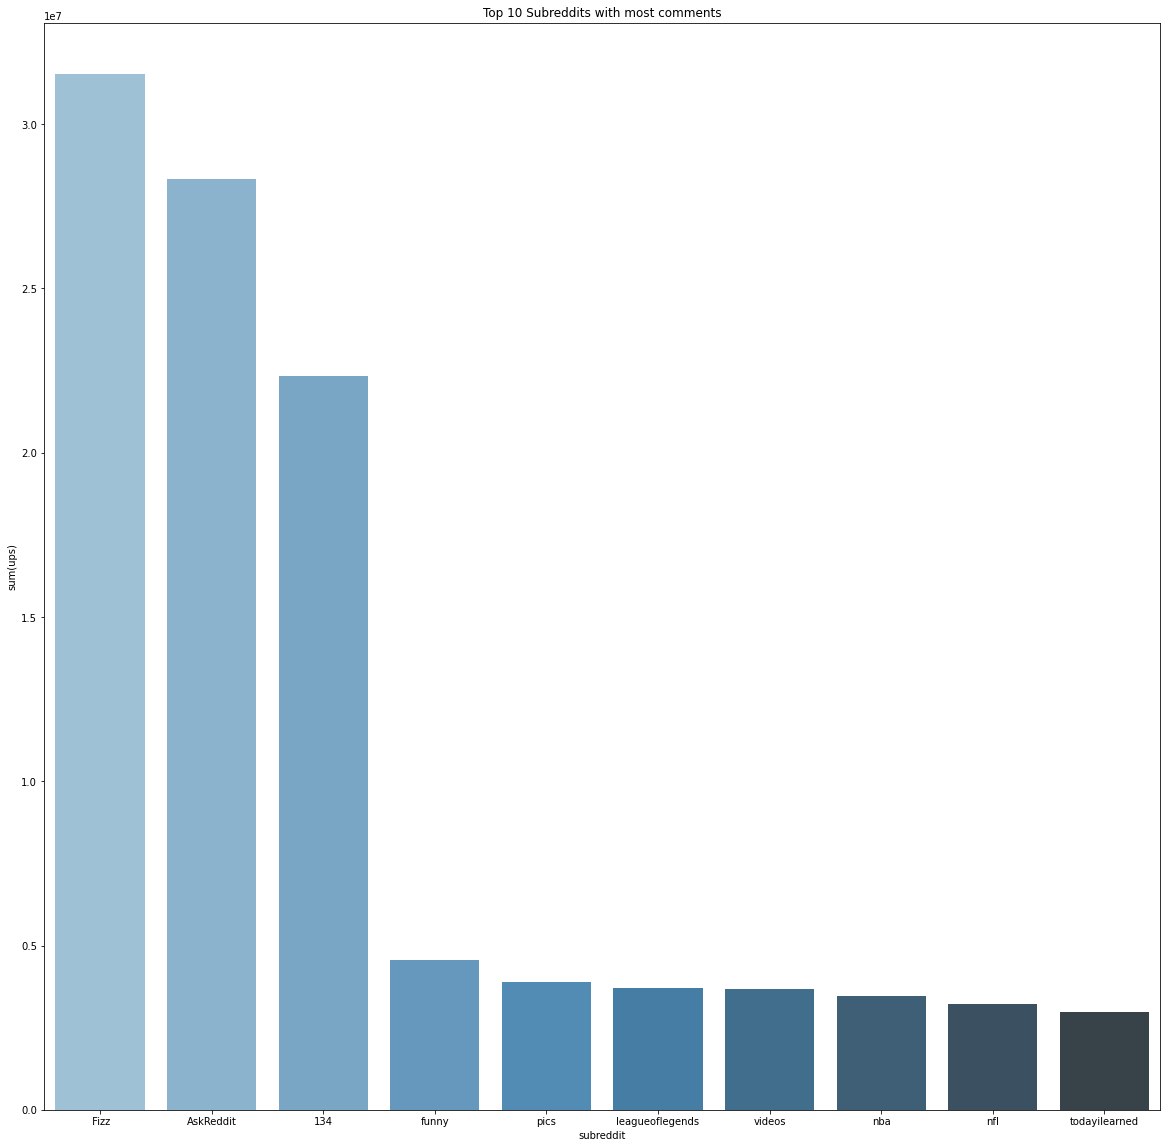

In [138]:
plt.subplots(figsize=(20, 20))
sns.barplot(x='subreddit',y='sum(ups)',data=new_ups_df,palette = "Blues_d")
plt.title('Top 10 Subreddits with most comments')

Wordcloud for top 10 most active subreddits 

In [24]:
fil_df = df.filter((df.subreddit == 'AskReddit') | (df.subreddit == 'leagueoflegends') 
                         |(df.subreddit == 'nba') | (df.subreddit == 'funny') |(df.subreddit == 'nfl') 
                        | (df.subreddit == 'pics') | (df.subreddit == 'videos') |(df.subreddit == 'news') 
                        | (df.subreddit == 'todayilearned') | (df.subreddit == 'pcmasterrace')  )

In [25]:
wordcloud_text = fil_df.select(df.subreddit,df.body)

In [26]:
wordcloud_text_askR = wordcloud_text.filter(wordcloud_text.subreddit == 'AskReddit')
wordcloud_text_league = wordcloud_text.filter(wordcloud_text.subreddit == 'leagueoflegends')
wordcloud_text_nba = wordcloud_text.filter(wordcloud_text.subreddit == 'nba')
wordcloud_text_funny = wordcloud_text.filter(wordcloud_text.subreddit == 'funny')
wordcloud_text_nfl = wordcloud_text.filter(wordcloud_text.subreddit == 'nfl')
wordcloud_text_pics = wordcloud_text.filter(wordcloud_text.subreddit == 'pics')
wordcloud_text_videos = wordcloud_text.filter(wordcloud_text.subreddit == 'videos')
wordcloud_text_news = wordcloud_text.filter(wordcloud_text.subreddit == 'news')
wordcloud_text_today = wordcloud_text.filter(wordcloud_text.subreddit == 'todayilearned')
wordcloud_text_pc = wordcloud_text.filter(wordcloud_text.subreddit == 'pcmasterrace')






In [106]:
#wordcloud_text_askR_pd = wordcloud_text_askR.toPandas() 
#wordcloud_text_league_pd = wordcloud_text_league.toPandas()
#wordcloud_text_nba_pd = wordcloud_text_nba.toPandas()
#wordcloud_text_funny_pd = wordcloud_text_funny.toPandas()
#wordcloud_text_nfl_pd = wordcloud_text_nfl.toPandas()
#wordcloud_text_pics_pd = wordcloud_text_pics
#wordcloud_text_videos_pd = wordcloud_text_videos
#wordcloud_text_news_pd = wordcloud_text_news.toPandas()
wordcloud_text_today_pd = wordcloud_text_today.toPandas()
#wordcloud_text_pc_pd = 





In [99]:
wordcloud_text_league_pd.shape

(673175, 2)

In [11]:
#wordcloud_text_pd = wordcloud_text.toPandas()
wordcloud_text.show()

+---------------+--------------------+
|      subreddit|                body|
+---------------+--------------------+
|            nba|gg this one's ove...|
|      AskReddit|No one has a Euro...|
|      AskReddit|"That the kid ""....|
|      AskReddit|                NSFL|
|  todayilearned|Get back to your ...|
|           pics|Me too. Same hamm...|
|leagueoflegends|well i think new ...|
|      AskReddit|I'm a guy and I h...|
|      AskReddit|Mid twenties male...|
|         videos|Because we aren't...|
|            nba|Well yeah. The fi...|
|      AskReddit|Fran Drescher lau...|
|      AskReddit|I honestly wouldn...|
|      AskReddit|             &lt;/3 |
|      AskReddit|no money, just ID...|
|            nba|**[STREAMLINK](ht...|
|           news|1-She got to be a...|
|            nfl|"Do you get to ju...|
|      AskReddit|Smoking tobacco. ...|
|            nfl|https://i.imgur.c...|
+---------------+--------------------+
only showing top 20 rows



In [107]:
#text = wordcloud_text_news_pd['body'].values


text = wordcloud_text_today_pd['body'].values
#text2 = wordcloud_text_askR_pd['body'].values[1000:2000]

In [109]:
text

array(['Get back to your pott harry.',
       "This shouldn't be fucking with me as much as it is",
       '/r/DickPics4Freedom [NSFW]',
       'Michigan is a pretty decent place to live.   ',
       'Especially since most deaths back then happened when the fighting was pretty much done and one army began to rout.',
       'Yup, that was the scariest part as a kid to me.... kinda like the [tunnel scene](https://www.youtube.com/watch?v=s62msrPjSVY) in Willy Wonka and the Chocolate Factory.',
       'I did this. I AM THE 6%! AMA!',
       '100000 soldiers managed to kill only 800 Romans, proper embarrassment',
       '2 different wars',
       'I was responding solely to the first sentence.', '"""King"". ',
       '[deleted]',
       'were you alive to see any of those productions run originally? ',
       "You're right, I just have other priorities right now, career wise.",
       "To those who live in the UK, *(I'm an American but I visited England around about the year 2000)* why does

In [110]:
#bucket_name="reddit-data-team-1"
#path2=f"gs://{bucket_name}/nba-logo-72dpi.png"
#im1 = Image.open(path2)
#nba_mask = np.array(im1)
stopwords = set(STOPWORDS)


In [111]:
wordcloud = WordCloud(background_color="white",max_font_size=50, max_words=20,stopwords=stopwords ).generate(str(text))

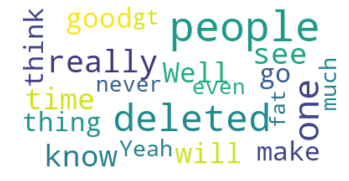

<Figure size 1440x1440 with 0 Axes>

In [112]:

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=[20,20])
plt.show()

average score of comments

In [27]:
most_liked = fil_df.groupby('subreddit').agg({'score': 'mean'})

In [28]:
most_liked_pd = most_liked.toPandas()

In [29]:
most_liked_pd = most_liked_pd.sort_values(by=['avg(score)'],ascending =[False])

Text(0.5, 1.0, 'Average Score for Top 10 Subreddits')

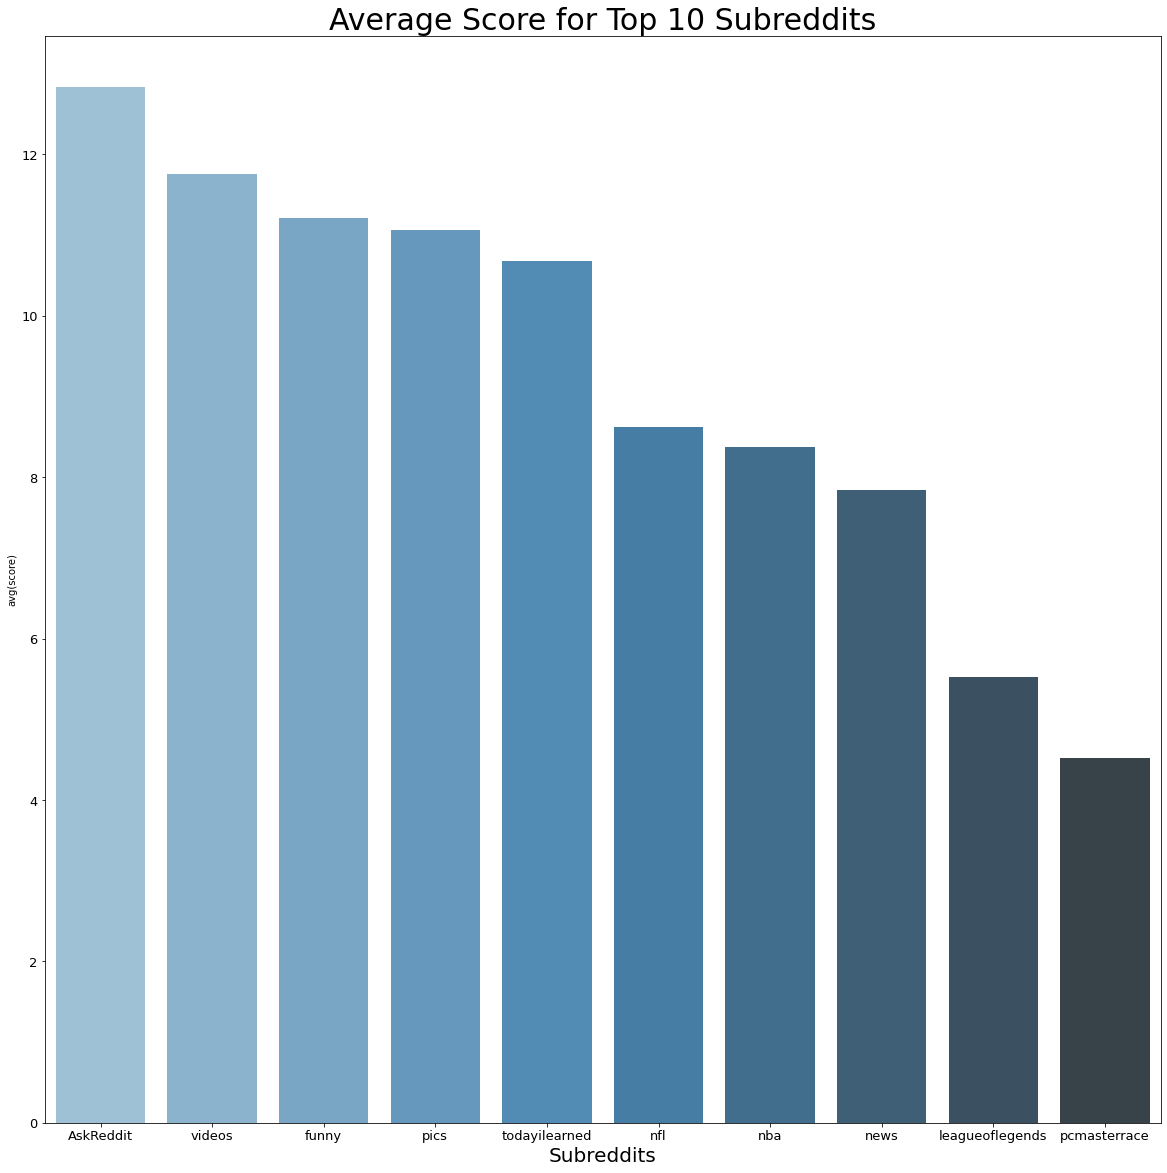

In [32]:

plt.subplots(figsize=(20, 20))
b = sns.barplot(x='subreddit',y='avg(score)',data=most_liked_pd,palette="Blues_d")
b.set_xlabel("Subreddits",fontsize=20)
b.tick_params(labelsize=13)
plt.title('Average Score for Top 10 Subreddits',fontsize=30)

In [121]:
most_liked.show(truncate=False)

+---------------+------------------+
|subreddit      |avg(score)        |
+---------------+------------------+
|AskReddit      |12.829233204767869|
|videos         |11.75223117109273 |
|pcmasterrace   |4.516915666554963 |
|todayilearned  |10.677064088019735|
|news           |7.84259579218777  |
|pics           |11.063306932995319|
|nfl            |8.625511049390495 |
|leagueoflegends|5.526894195417239 |
|nba            |8.373794348790588 |
|funny          |11.208711139498606|
+---------------+------------------+



In [33]:
most_gilded = fil_df.groupby('subreddit').agg({'gilded': 'mean'})

In [34]:
most_gilded_pd = most_gilded.toPandas()

In [35]:
most_gilded_pd = most_gilded_pd.sort_values(by=['avg(gilded)'],ascending =[False])

Text(0.5, 1.0, 'Ratio of Gilded to Non Gilded Comments')

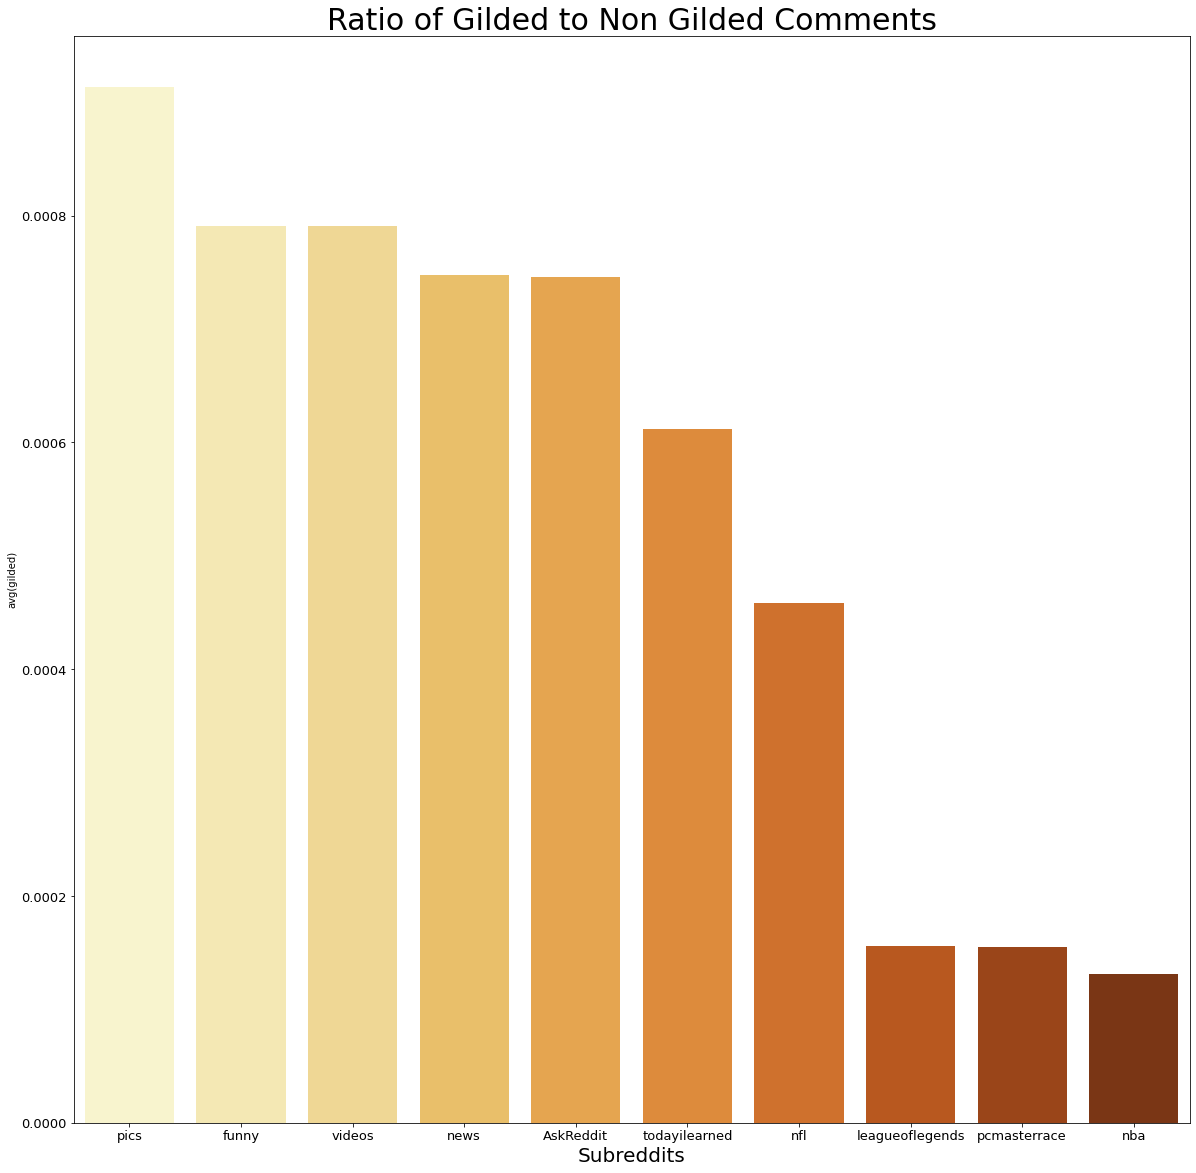

In [39]:
plt.subplots(figsize=(20, 20))
b= sns.barplot(x='subreddit',y='avg(gilded)',data=most_gilded_pd,palette="YlOrBr")
b.set_xlabel("Subreddits",fontsize=20)
b.tick_params(labelsize=13)
plt.title('Ratio of Gilded to Non Gilded Comments',fontsize=30)


